In [1]:
#Import Packages
##Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.signal import find_peaks

In [4]:
coin_data = pd.read_csv("Data/Coincidence_Measurements - Sheet1.csv", skipfooter=4, engine="python") # names=init_run_cols,

coin_data

,Angle,d_Angle,RunTime,Run1,Run2,Run_Avg,Run_Std,d_Count
0,42,0.1,90,945,908,927,26,0.0282
1,46,0.1,90,885,928,907,30,0.0335
2,50,0.1,90,898,884,891,10,0.0111
3,54,0.1,90,905,911,908,4,0.0047
4,58,0.1,90,958,926,942,23,0.0240
5,62,0.1,90,1305,1349,1327,31,0.0234
6,66,0.1,90,2332,2461,2397,91,0.0381
7,70,0.1,90,4157,4231,4194,52,0.0125
8,74,0.1,90,5963,5980,5972,12,0.0020
9,78,0.1,90,8890,8937,8914,33,0.0037


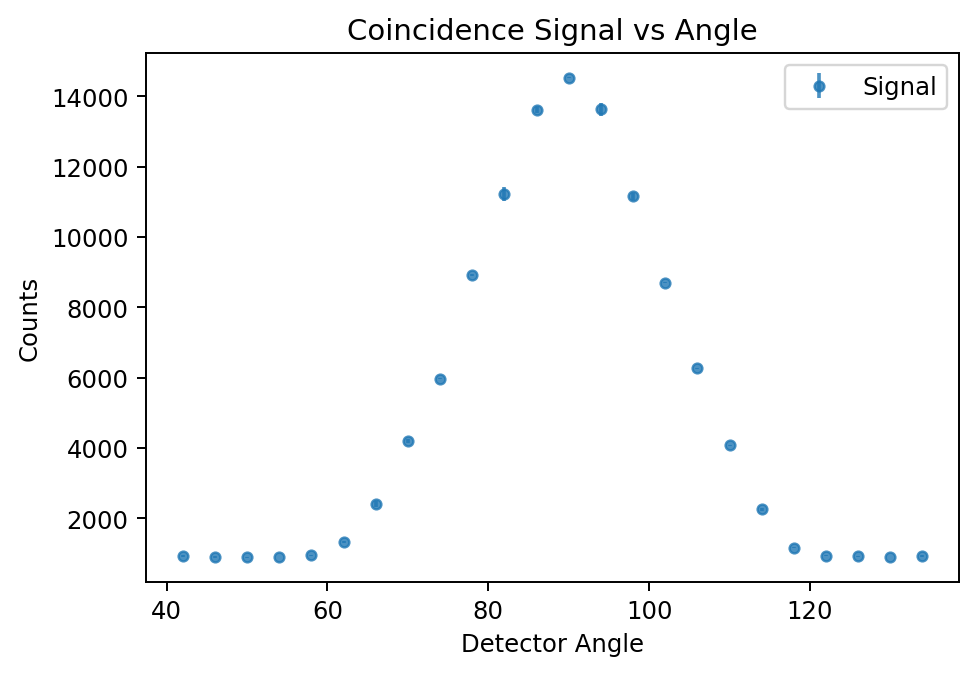

In [11]:
plt.figure(dpi=175)
plt.title("Coincidence Signal vs Angle")
plt.xlabel("Detector Angle")
plt.ylabel("Counts")

plt.errorbar(coin_data["Angle"].iloc[:-1], coin_data["Run_Avg"].iloc[:-1], yerr=coin_data["Run_Std"].iloc[:-1], 
             fmt="o", ms=4, alpha=.8, label="Signal")
plt.legend()
#plt.yscale("log")
#plt.ylim(1,10**5)
#plt.legend()

#plt.savefig("Plots/Background.pdf")
plt.show()

# Fitting


[3.98872304e+05 9.01568688e+01 1.17355055e+01 7.88916488e+02]
[3.70163075e+03 9.06866635e-02 9.58544595e-02 3.47613072e+01]
[0.92802401 0.10058764 0.81679021 4.40620873]


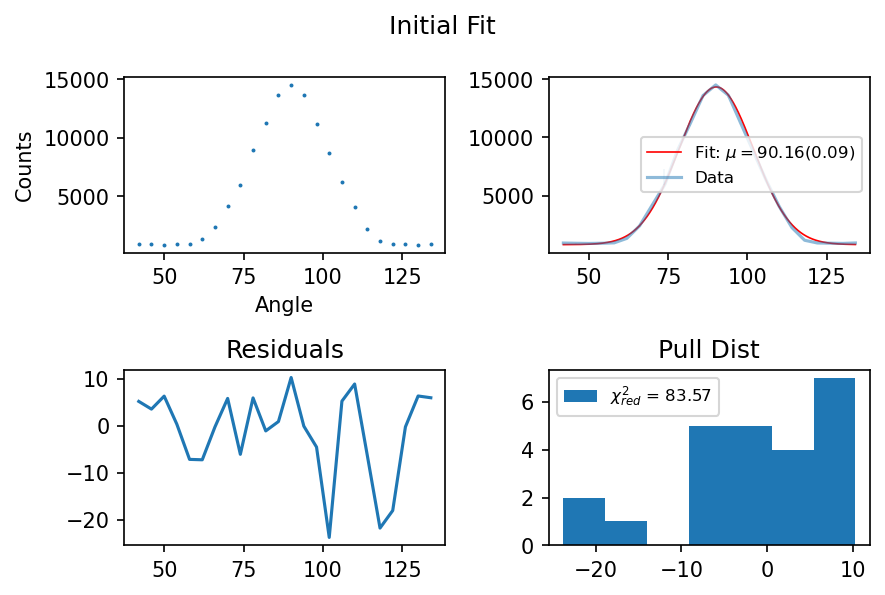

CPU times: user 896 ms, sys: 118 ms, total: 1.01 s
Wall time: 1.03 s


In [20]:
%%time
def Gaussian(x, A,mu,sigma, c):
    return A*scipy.stats.norm.pdf(x, mu, sigma) + c

func = Gaussian

##Get Hist
plt.figure(dpi=150)
plt.suptitle(f"Initial Fit")
plt.subplot(2, 2, 1)
plt.xlabel("Angle")
plt.ylabel("Counts")

keeps = np.abs(coin_data["Angle"]) < 130

removes = [-1]#[6, 10, 11]

run_num = 2

if len(removes) != 0:
    Angle = np.delete(coin_data["Angle"].values, removes)#[keeps]
    Counts = np.delete(coin_data["Run_Avg"].values, removes)#[keeps]
    errors = np.delete(coin_data["Run_Std"].values, removes)
    
else:
    Angle = coin_data["Angle"].values
    Counts = coin_data["Run_Avg"].values
    errors = coin_data["Run_Std"].values

plt.scatter(Angle, Counts, s=.8)


#pars, cov = scipy.optimize.curve_fit(single_Gauss, frequency.values, signal.values, #maxfev=3*10**5, sigma=errors,
#                                     p0=[3,460,20, 1],
#                                     bounds=([0.01,380,1, 0],
#                                             [5,520,200, 1.5]))
pars, cov = scipy.optimize.curve_fit(func, Angle, Counts, maxfev=3*10**5, sigma=errors,
                                     p0=[15000, 90, 20, 1000],
                                     #bounds=([10**-12,0.04,0, -10], [10**-5,1,1*10**-4, -0.1])
                                    )
#Mean Lines
"""plt.vlines(pars[1],np.min(Counts),np.max(Counts)*1.2, 
           label=f"{pars[1]:.2E} ({np.sqrt(cov.diagonal())[1]:.2E})", color="blue", lw=0.5)
plt.hlines(pars[-2],np.min(Angle),np.max(Angle), 
           label=f"{pars[-2]:.2E} ({np.sqrt(cov.diagonal())[-2]:.2E})", color="red", lw=0.5)

plt.legend(title="Lines", prop={"size":6})"""

#Plot Fit
plt.subplot(2, 2, 2)
x = np.arange(np.min(Angle),np.max(Angle),0.001)

plt.errorbar(Angle, Counts, yerr=errors, 
             ms=.2, elinewidth=.1, alpha=0.5, label="Data")
plt.plot(x, func(x, *pars), color="red", lw=.8, label=f"Fit: $\mu={pars[1]:2.2f} ({np.sqrt(cov[1,1]):.2f})$")
plt.legend(prop={"size":8})
#plt.xscale("log")
#plt.set_xticks(np.arange(300,901,50), minor=1)

print(pars)
print(np.sqrt(cov.diagonal()))
print(np.sqrt(cov.diagonal())/np.abs(pars)*100)

#Residuals
residuals = (Counts-func(Angle, *pars))/errors
plt.subplot(2, 2, 3)
plt.title("Residuals")
plt.plot(Angle, residuals)#, s=1)

#Pull Dist
plt.subplot(2, 2, 4)
plt.title("Pull Dist")
red = "{red}"
plt.hist(residuals, 7, label=f"$\chi_{red}^2$ = {np.sum(residuals**2)/len(residuals):.2f}")
plt.legend(prop={"size":8})

plt.tight_layout()
plt.savefig(f"Plots/Bi_Run{run_num}_Fit.pdf")
plt.show()